In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def plot_signal(result):
    plt.figure(figsize=(20,1)) 
    plt.plot(np.arange(len(result)), result) #just print one example from the batch
    plt.show()

In [57]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth64_76/dataset'
paramdir = 'data/synth64_76/dataparams'
loadmodelpath = 'experiments/teacherforcing/models/2018-11-13_13-16-31_model_epoch1_tf1.pth'

# Pytorch parameters
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
#batch_size = 256
#num_epochs = 1
#lr = 0.005
#log_interval = 50
#max_steps = 2000

#Generation parameters
#*************************************
max_length = seqLen*8

In [36]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'amplitude', 'midiPitch'])


In [37]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)
rescalePitch = normalizeDim('midiPitch',64,76)
rescaleAmp = normalizeDim('amplitude',0,0.9)

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

In [38]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [39]:
# Define generate
#*************************************
def generate(model,max_length,primer=None,paramvect=None):
    model.eval()
    with torch.no_grad():
        for p_inp,target in test_loader:
            if primer is not None:
                # must clone else primer is changed outside this function
                p_inp.data = primer.clone()
            seq = np.copy(p_inp[0,:,0])  #extract the original sample
            seq_mu = audiocoding(seq)  #mu-law
            p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
            break  
        generated = seq
        p_inp = p_inp.to(device)
        #print(p_inp)

        hidden = model.init_hidden()
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)
            #print("input",inp)
            #print("shape",inp.shape)
            if paramvect is not None:
                if callable(paramvect):
                    inp[:,1:] = torch.from_numpy(paramvect(i)).type(torch.FloatTensor).to(device)
                else:
                    inp[:,1:] = torch.from_numpy(paramvect).type(torch.FloatTensor).to(device)
                #print("input2",inp)
                                       
        return generated
        

In [58]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(input_size=1,cond_size=3,hidden_size=40,output_size=256,n_layers=4).to(device)
print("Loading existing checkpoint...")
rnn.load_state_dict(torch.load(loadmodelpath))

Loading existing checkpoint...


In [59]:
# Priming
#*************************************
#if primer=None, will pick random sample from testdataset (via testloader) to prime
#else can define own array with shape (1,seqLen,cond_size+1)

# Make noisy Priming signal 
myp=np.zeros([1,seqLen,4])
# !! PRIMING DOES MATTER - has to be a certain level of noise
myp[0,:,0]=(.4*np.random.ranf([seqLen]))-.2 #signal
myp[0,:,1]= np.random.ranf([seqLen])     #instrument
myp[0,:,2]= np.random.ranf([seqLen])    #volume
myp[0,:,3]= np.random.ranf([seqLen])    #pitch
myprimer=torch.tensor(myp, dtype=torch.float, device=device)

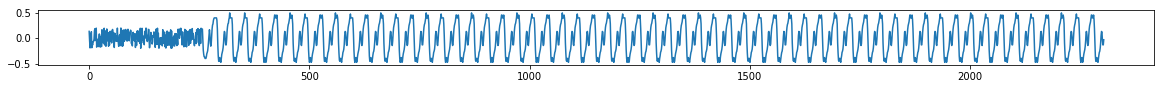

In [60]:
# Generate!
#*************************************
#Conditional parameters
#paramvect can either take in an array shaped (cond_size) 
#or a function (e.g see fsweep below) if want to change values over time

paramvect = np.array([0,0.5,0.5])
signal = generate(rnn,max_length,primer=myprimer,paramvect=paramvect)
plot_signal(signal)

In [61]:
from ipywidgets import interact,interactive
from ipywidgets import FloatSlider
from IPython.display import Audio, display

def widgetfunc(x,y,z):
    paramvect = np.array([x,y,z])
    signal = generate(rnn,max_length,primer=None,paramvect=paramvect)
    plot_signal(signal[seqLen:seqLen*3])
    display(Audio(data=signal[seqLen:],rate=sr))
    return signal
    
xslider=FloatSlider(min=0, max=1, step=.01, value=0.0, continuous_update=False, description='instID')
yslider=FloatSlider(min=0, max=1, step=.01, value=1.0, continuous_update=False, description='amplitude')
zslider=FloatSlider(min=0, max=1, step=.01, value=0.0,  continuous_update=False, description='midiPitch')

w = interactive(widgetfunc, x=xslider, y=yslider, z=zslider)
display(w)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='instID', max=1.0, step=0.01…

signal length is 16000
p length is 1


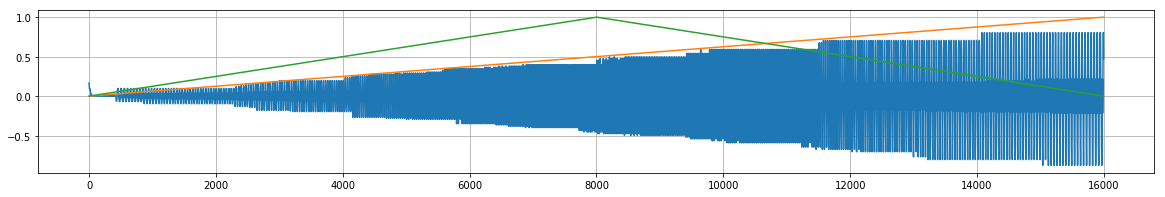

In [63]:
genlen= int(1*sr) #not including priming

def fsweep(snum) :   #nsnum is sample number not including priming
    t=snum/genlen #snum/params['sample_rate']
    p=2*(.5-np.abs(.5-t))
    #v=.5*2*(.5-np.abs(.5-t))
    """
    if (t<0.01) :
        v=0
    elif t<.3 :
        v=.5
    elif t<.5 :
        v=0
    elif t<.7 :
        v=1
    else :
        v=0
    """
    i=1
    v=t
    return np.array([i,v,p]) 


signal = generate(rnn,genlen, primer=myprimer, paramvect=fsweep)
#plot_signal(signal)

p = [fsweep(t) for t in range(genlen)]
q = [x[1:3] for x in p]

print("signal length is {}".format(len(signal[seqLen:])))
print("p length is {}".format(len(p[1:2])))

plt.figure(figsize=(20,3)) 
plt.plot(np.arange(len(signal[seqLen:])), signal[seqLen:]) 
#plt.plot(np.arange(len(signal[256:])), p[:,2]) 
plt.plot(np.arange(len(q)), q)
plt.grid()
plt.show()

display(Audio(signal, rate=sr, autoplay=False))